# Predicting House Prices on [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Accessing and Reading Data Sets

In [2]:
import requests
import io
# We simply use the dataest hosted by D2L, not from kaggle
kaggle_train_url="http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_train.csv"
kaggle_test_url="http://d2l-data.s3-accelerate.amazonaws.com/kaggle_house_pred_test.csv"
train_data = pd.read_csv(kaggle_train_url)
test_data = pd.read_csv(kaggle_test_url)
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


## A Quick View of the Data

In [3]:
train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


## Combile Train and Test for Pre-processing

In [4]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## Standardize and Replace Missing Value with 0

In [5]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features = all_features.fillna(0)

## Replace Discrete Feature with One-hot Encoding 

In [6]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 354)

## Preprocessed Dataset

In [7]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float32).reshape((-1, 1))

## Linear Regression with L2 Loss

In [8]:
loss = nn.MSELoss()

def init_weights(m):
    if type(m) == nn.Linear:
        # Initialize weight parameter by a normal distribition 
        # with a mean of 0 and standard deviation of 0.01.
        nn.init.normal_(m.weight.data, std=0.01)
        # The bias parameter is initialized to zero by default.
        m.bias.data.fill_(0.0)
        
def get_net():
    net = nn.Sequential(nn.Linear(train_features.shape[1], 1))
    return net

## Log Root Mean Square Error 

$$L = \sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}$$

A small value $\delta$ of $\log y - \log \hat{y}$ translates into $e^{-\delta} \leq \frac{\hat{y}}{y} \leq e^\delta$. 


In [9]:
def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.item()

## A less LR insenstive Adam Optimizatier 

In [10]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_features,train_labels), 
        batch_size, shuffle=True)
    trainer = torch.optim.Adam(net.parameters(), lr = learning_rate, weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            with torch.enable_grad():
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## Get k-Fold Cross-Validation Data

In [11]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

##  k-Fold Cross-Validation

In [12]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """Plot x and log(y)."""
    plt.rcParams['figure.figsize'] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()

def k_fold(k, X_train, y_train, num_epochs,
           learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        net.apply(init_weights)
        train_ls, valid_ls = train(net, data[0],data[1],data[2],data[3], num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                        range(1, num_epochs + 1), valid_ls,
                        ['train', 'valid'])
        print('fold %d, train rmse: %f, valid rmse: %f' % (
            i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

## Model Selection


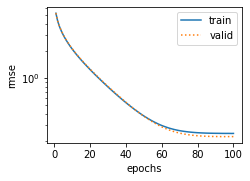

fold 0, train rmse: 0.240570, valid rmse: 0.221782
fold 1, train rmse: 0.229295, valid rmse: 0.267302
fold 2, train rmse: 0.232107, valid rmse: 0.238200
fold 3, train rmse: 0.237700, valid rmse: 0.218658
fold 4, train rmse: 0.229785, valid rmse: 0.258525
5-fold validation: avg train rmse: 0.233891, avg valid rmse: 0.240893


In [13]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print('%d-fold validation: avg train rmse: %f, avg valid rmse: %f'
      % (k, train_l, valid_l))

##  Predict and Submit

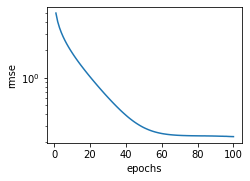

train rmse 0.229850


In [14]:
def train_and_pred(train_features, test_feature, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    net.apply(init_weights)
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)        